## Reddit data-set for sarcasm detection (pt 2)

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

In [3]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

## Analysis on the comments

In order to prove that one of the causes of the low performances of the algorithms might be the fact that we are indirectly computing the probability of receiving a sarcastic comment considering the parent comments and not the comments themselves, to which the label actually refer, we will conduct the same analysis as in part 1 focusing on the comments.

In [5]:
reddit = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
reddit.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [6]:
reddit.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [7]:
reddit = reddit[reddit['comment'].notna()]
reddit.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [8]:
red_sample = reddit.sample(frac = 0.2) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1]) 

202155
10


In [9]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [10]:
# We drop all the columns but the label, the comment and the subreddit ones:
red_sample.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
red_sample.head(10)

,label,comment,subreddit
367523,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions
767345,1,OBAMA!,shortscarystories
945892,0,The Welsh would certainly be the exception to ...,AdviceAnimals
107043,1,REPOST!,pcmasterrace
369596,1,My left or your left?,MINI
458916,0,The sad part is I don't believe those two even...,conspiracy
257267,1,"Yeah, what a hard life.",food
364533,0,"to be fair, something appealing to women in th...",xboxone
538029,0,They really need to rework his whole kit.,leagueoflegends
578049,1,Oh now it makes sense,baseball


In [11]:
red_sample = red_sample.reset_index(drop=True)
red_sample

,label,comment,subreddit
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions
1,1,OBAMA!,shortscarystories
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals
3,1,REPOST!,pcmasterrace
4,1,My left or your left?,MINI
...,...,...,...
202150,0,"""I drank what?""",pics
202151,1,"PEOPLE ARE HAPPY, HOW ANNOYING!",videos
202152,1,Are you sure it's looters and not early Black ...,Conservative
202153,1,Not nearly as impressive as Doug Baldwin's 3 g...,nfl


In [12]:
# Find the number of characters for each string in the red_sample dataset
red_sample['char'] = red_sample['comment'].str.len()
red_sample.head()

,label,comment,subreddit,char
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions,94
1,1,OBAMA!,shortscarystories,6
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals,58
3,1,REPOST!,pcmasterrace,7
4,1,My left or your left?,MINI,21


In [13]:
# Number of punctuation symbols
red_sample['punct'] = red_sample['comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_sample.head()

,label,comment,subreddit,char,punct
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions,94,2
1,1,OBAMA!,shortscarystories,6,1
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals,58,1
3,1,REPOST!,pcmasterrace,7,1
4,1,My left or your left?,MINI,21,1


In [14]:
# Find the number of tokens for each string in the red_sample dataset
red_sample['tokens'] = red_sample['comment'].str.split().str.len()
red_sample.head()

,label,comment,subreddit,char,punct,tokens
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions,94,2,16
1,1,OBAMA!,shortscarystories,6,1,1
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals,58,1,11
3,1,REPOST!,pcmasterrace,7,1,1
4,1,My left or your left?,MINI,21,1,5


In [15]:
# Cleaning the text of the comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [16]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_sample["clean"] = red_sample["comment"].apply(cleanText)
red_sample.head()
endTime = timer()

In [17]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 9.0 minutes and 15.3 seconds


In [18]:
red_copy = red_sample.copy()

## Wordcloud
We try wordcloud with the first comment of the dataset.

We now need a Legend of Zelda: Four Swords Adventures-style h3h3 fan game using these sprites.


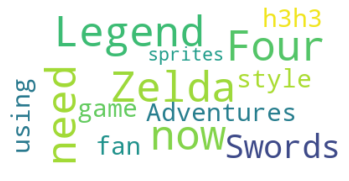

In [19]:
# Start with the first parent comment:
from wordcloud import WordCloud
example = red_sample.comment[0]
print(example)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(example)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Wordcloud on all the comments.

In [20]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['comment'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

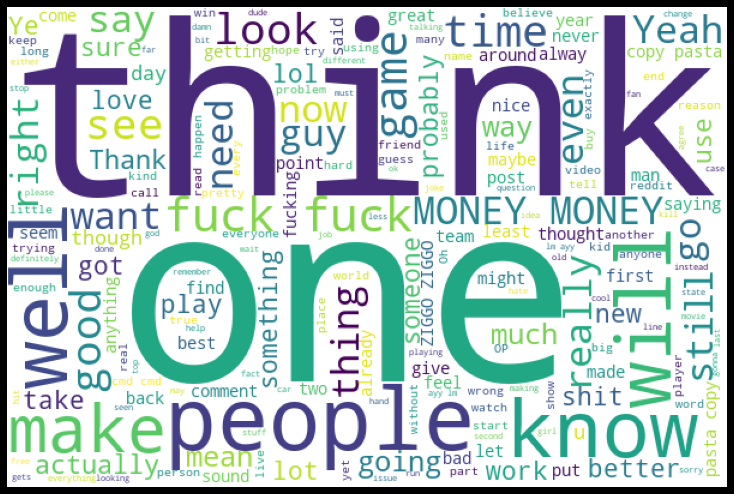

In [21]:
myWordCloud(0)

Wordcloud for Sarcastic comments:

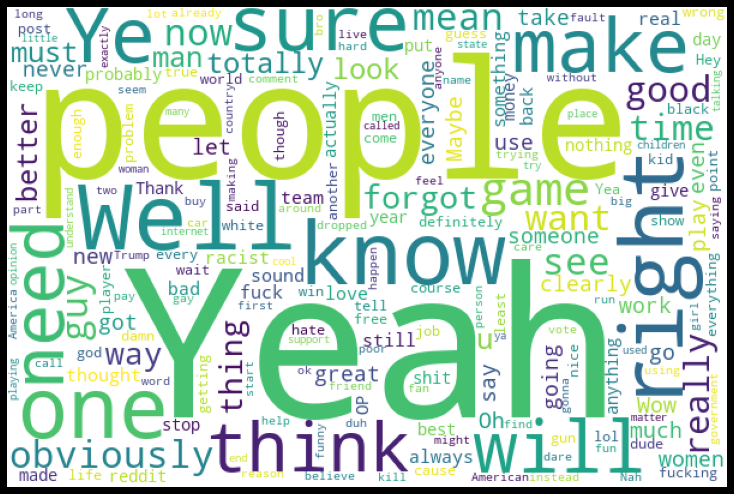

In [22]:
myWordCloud(1)

#### Wordcloud with the cleaned version of the comments:

In [23]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['clean'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

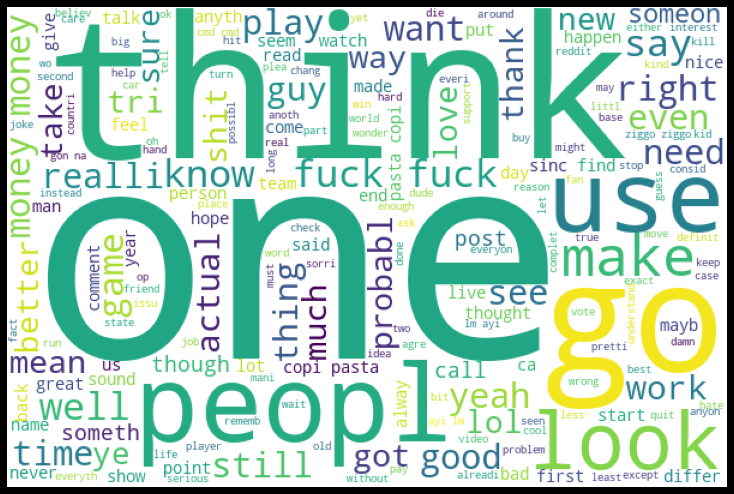

In [24]:
myWordCloudCleaned(0)

Wordcloud for Sarcastic comments:

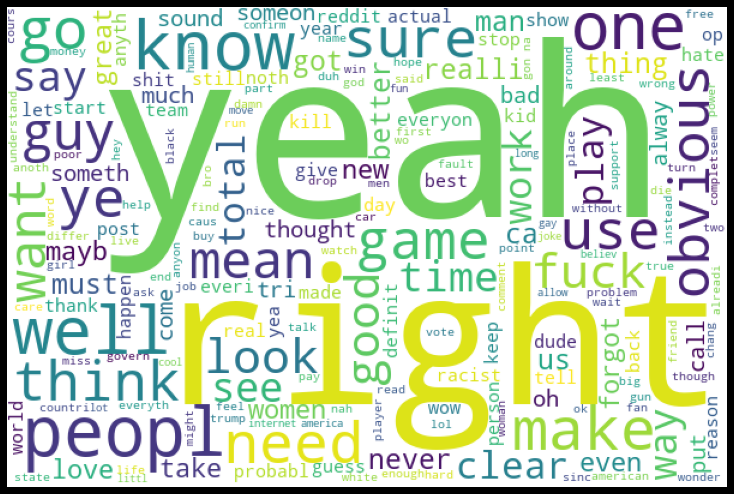

In [25]:
myWordCloudCleaned(1)

## Split into train and test sets

In [26]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

7631

In [27]:
X = red_sample[['clean','subreddit']]
y = red_sample['label']

In [28]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [29]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [30]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(129379, 2)
(32345, 2)
(40431, 2)
(129379,)
(32345,)
(40431,)


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned comments
TF-IDF focusing on the comments from which we have removed the punctuation and on which we have performed stemmization.

In [31]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
comment_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=3)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [33]:
clean_train = comment_vectorizer.fit_transform(red_train['clean'])
clean_valid = comment_vectorizer.transform(red_val['clean'])
clean_test = comment_vectorizer.transform(red_test['clean'])

In [34]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [35]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### First Alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### Naive Bayes

In [37]:
naive_bayes = NB.fit(reddit_train, y_train)

In [38]:
naiveBayes_predict = NB.predict(reddit_test)

In [39]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.654102050406866

With Cross Validation

In [40]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [41]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.65442881, 0.6480136 , 0.65504715, 0.64770444, 0.65171014])

#### Logistic Regression

In [42]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [43]:
## Fit the model
logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.9s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [44]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit.predict_proba(reddit_test)[:,1])

0.731928854277957

With Cross validation:

In [45]:
logit_cv = cross_val_score(logit, reddit_train, y_train, n_jobs = -1)
logit_cv

array([0.67158757, 0.67093059, 0.66837997, 0.66304684, 0.67049275])

#### Random forest

In [46]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest.fit(reddit_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [47]:
randomForest_predict = random_forest.predict(reddit_test)

In [48]:
metrics.accuracy_score(y_test, randomForest_predict)

0.5399569637159606

With Cross validation:

In [49]:
rf_cv = cross_val_score(random_forest, reddit_train, y_train, n_jobs = -1)
rf_cv

array([0.55418148, 0.53512908, 0.55155356, 0.55398825, 0.54651208])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [50]:
red_sample.head()

,label,comment,subreddit,char,punct,tokens,clean
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions,94,2,16,need legend zelda four sword fan game use sprite
1,1,OBAMA!,shortscarystories,6,1,1,obama
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals,58,1,11,welsh would certain except said
3,1,REPOST!,pcmasterrace,7,1,1,repost
4,1,My left or your left?,MINI,21,1,5,left left


In [51]:
red_sample['text'] = red_sample.clean + " " + red_sample.subreddit
red_sample.head()

,label,comment,subreddit,char,punct,tokens,clean,text
0,0,We now need a Legend of Zelda: Four Swords Adv...,h3h3productions,94,2,16,need legend zelda four sword fan game use sprite,need legend zelda four sword fan game use spri...
1,1,OBAMA!,shortscarystories,6,1,1,obama,obama shortscarystories
2,0,The Welsh would certainly be the exception to ...,AdviceAnimals,58,1,11,welsh would certain except said,welsh would certain except said AdviceAnimals
3,1,REPOST!,pcmasterrace,7,1,1,repost,repost pcmasterrace
4,1,My left or your left?,MINI,21,1,5,left left,left left MINI


In [52]:
# We drop all the columns of the comments and that containing the cleaned text:
red_sample.drop(['comment', 'clean'], axis=1, inplace=True)
red_sample.head(10)

,label,subreddit,char,punct,tokens,text
0,0,h3h3productions,94,2,16,need legend zelda four sword fan game use spri...
1,1,shortscarystories,6,1,1,obama shortscarystories
2,0,AdviceAnimals,58,1,11,welsh would certain except said AdviceAnimals
3,1,pcmasterrace,7,1,1,repost pcmasterrace
4,1,MINI,21,1,5,left left MINI
5,0,conspiracy,131,3,25,sad part believ two event relat simpli doubt a...
6,1,food,23,2,5,yeah hard life food
7,0,xboxone,111,1,23,fair someth appeal women day someth men night ...
8,0,leagueoflegends,41,1,8,realli need rework whole kit leagueoflegends
9,1,baseball,21,0,5,oh make sens baseball


#### Wordclouds with the new text:

In [53]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['text'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

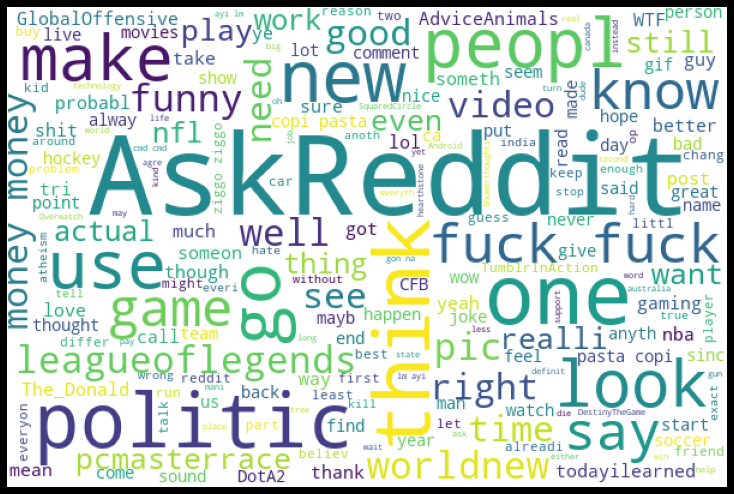

In [54]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

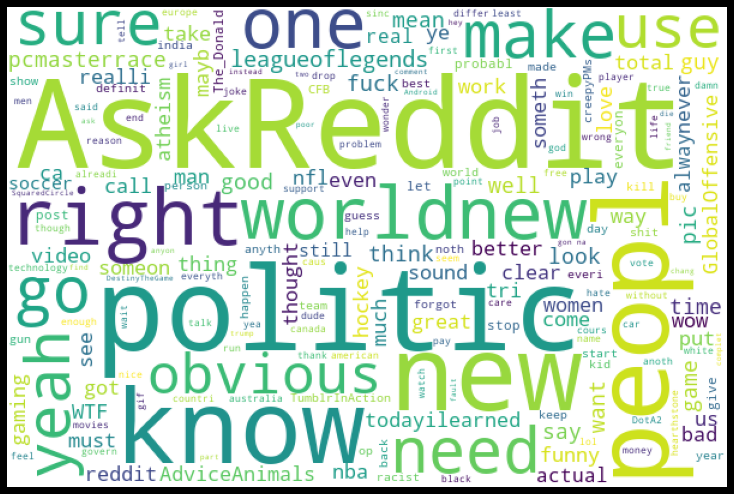

In [55]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [56]:
X2 = red_sample[['text']]
y2 = red_sample['label']

In [57]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [58]:
reddit_train2 = comment_vectorizer.fit_transform(X_train2['text'])
reddit_test2 = comment_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [59]:
naive_bayes2 = NB.fit(reddit_train2, y2_train)

In [60]:
naiveBayes_predict2 = NB.predict(reddit_test2)

In [61]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.6607553609853825

Cross Validation:

In [62]:
NB_cv2 = cross_val_score(NB, reddit_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.66303911, 0.65855619, 0.66254444, 0.65889627, 0.65873114])

#### Random forest

In [63]:
random_forest.fit(reddit_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [64]:
randomForest_predict2 = random_forest.predict(reddit_test2)

In [65]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5348618634216319

Cross Validation:

In [66]:
rf_cv2 = cross_val_score(random_forest, reddit_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.54462823, 0.54404081, 0.54252589, 0.53189055, 0.54714939])

#### Logistic regression

In [67]:
X3 = red_sample['text']
y3 = red_sample['label']

In [68]:
X_train3, red_test3, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=28)

In [69]:
from sklearn.pipeline import Pipeline
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [70]:
tfidf_logit_pipeline.fit(X_train3, y3_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.6s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [71]:
roc_auc_score(y3_test, tfidf_logit_pipeline.predict_proba(red_test3)[:,1])

0.7372799456812508

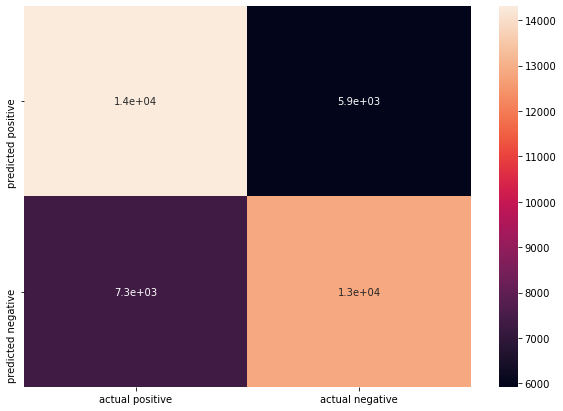

In [73]:
conf_mat3 = pd.DataFrame(confusion_matrix(y3_test, tfidf_logit_pipeline.predict(red_test3)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat3, annot=True)
plt.show()

GridSeachCV:

In [74]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [75]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [76]:
grid.fit(X_train3, y3_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   12.2s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   24.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [77]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2), use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train3, y3_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [78]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test3)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y3_test,predictions)),'\n')

Accuracy Score: 67.18% 

